# Theory for $\delta T(x)$ accounting for changes in WTG and CE
This extends the $\delta h(x) = \delta \overline{h}$ theory for the tropics with an additional term accounting for the fact that the current climate differs from convective equilibrium (CE) and constant free troposphere temperature gradient (WTG). 

It also quantifies the effect of changes to these two terms with warming.

In [113]:
import copy
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat
from isca_tools.utils.constants import kappa, L_v, c_p, g, R
from isca_tools.utils import area_weighting, annual_mean
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.thesis.adiabat_theory import (get_temp_adiabat, get_delta_mse_mod_anom_theory, get_theory_prefactor_terms,
                                              decompose_temp_adiabat_anomaly, get_delta_temp_quant_theory, get_delta_temp_quant_theory_simple, 
                                              get_delta_temp_quant_theory_simple2)
from isca_tools.utils.stats import z_score_from_confidence_interval
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy import integrate
import numpy_indexed
from scipy.stats import percentileofscore
import copy
from sklearn.linear_model import TheilSenRegressor
# Use custom matplotlib style for publishing
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')

In [2]:
# Load dataset - one at surface and one in free troposphere
var_keep = ['temp', 'sphum', 'height', 'klzbs', 'convflag']        # only keep variables required to compute relative humidity and MSE
# var_keep = ['temp', 'sphum', 'height', 'ucomp', 'vcomp']
# Load dataset
tau_lw_ref = 1
tau_lw_warm = 1.5
exp_dir = 'tau_sweep/aquaplanet/depth=1/'
# exp_dir = 'tau_sweep/aquaplanet/'
exp_names = [f"k={str(tau_lw_ref).replace('.','_')}", f"k={str(tau_lw_warm).replace('.','_')}"]
n_exp = len(exp_names)
ds = []
albedo = []
tau_sw = []
tau_lw = []
for i in range(n_exp):
    ds_use = isca_tools.load_dataset(exp_dir + exp_names[i])[var_keep]
    ds += [ds_use]      # only keep the surface values
    namelist = isca_tools.load_namelist(exp_dir + exp_names[i])  # Need this for albedo_value
    albedo += [namelist['mixed_layer_nml']['albedo_value']]
    tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
    tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]

## Get datasets
Get one surface dataset for summer for each $\kappa$, combining all latitudes: `ds_all`. This combines the summer months in each hemisphere, e.g. negative latitudes will only correspond to times in December, January or February.


In [3]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [4]:
# Compute Global Average Surface Temperature and get near surface temperature data
# Use all data after 2 years, as clearly converged from the above spin up plot
use_time_start = 360*2
pressure_ft = 500           # Desired approximate pressure of free troposphere (hPa)

# Tropics
region = 'tropics'
lat_min = 0
lat_max = 20
# Extratropics
# region = 'extratropics'
# lat_min = 40
# lat_max = 65
# Poles
# region = 'High Latitudes'
# lat_min = 70
# lat_max = 90
# region = 'Global'
# lat_min = 0
# lat_max = 90

# Chose whether to only consider summer days or consider all days
# season = 'all'
# season = 'summer'
season = 'winter'
if season == 'summer':
    if region == 'tropics':
        season_months = {'nh': [5, 6, 7, 8, 9, 10], 'sh': [11, 12, 1, 2, 3, 4]}   
    else:
        season_months = {'nh': [6, 7, 8], 'sh': [12, 1, 2]}   # JJA for NH and DJF for SH
elif season == 'winter':
    if region == 'tropics':
        season_months = {'sh': [5, 6, 7, 8, 9, 10], 'nh': [11, 12, 1, 2, 3, 4]}
    else:
        season_months = {'sh': [6, 7, 8], 'nh': [12, 1, 2]} 

ds_all = []
with tqdm(total=n_exp, position=0, leave=True) as pbar:
    for i in range(n_exp):
        ds_use = ds[i].sel(time=slice(use_time_start, np.inf))
        ds_use = ds_use.sel(pfull=[np.inf, pressure_ft], method='nearest')      # only keep the surface values - get rid of pfull coordinate
        ds_use = ds_use.where((np.abs(ds_use.lat) <= lat_max) & (np.abs(ds_use.lat) >= lat_min), drop=True)

        if season == 'summer' or season == 'winter':
            # Only consider summer as has expected circulation
            ds_nh_summer = isca_tools.utils.annual_time_slice(ds_use, season_months['nh']).sel(lat=slice(lat_min, lat_max)) 
            ds_sh_summer = isca_tools.utils.annual_time_slice(ds_use, season_months['sh']).sel(lat=slice(-lat_max, -lat_min))  
            # Combine hemispheres and average over longitude, time and latitude.
            # Note that April, May, June, October, November and December will not be included in this dataset
            ds_use = xr.concat([ds_sh_summer, ds_nh_summer], dim='lat')
        ds_use = ds_use.stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1))
        ds_all += [ds_use.load()]
        pbar.update(1)

ind_surf = 0
ind_ft = 1
p_surface = float(ds_all[0].pfull[ind_surf]) * 100
pressure_ft_actual = float(ds_all[0].pfull[ind_ft]) * 100       # Actual pressure of free troposphere (Pa)

100%|██████████| 2/2 [00:23<00:00, 11.95s/it]


## Definition of Summer
Below I look at the months that are convecting, to deduce a good definition of summer.

In [5]:
# annual_mean_lat_plot = 64
annual_mean_lat_plot = 18
annual_mean_tau_ind = 0
ds_annual_mean = annual_mean(ds[annual_mean_tau_ind].sel(time=slice(use_time_start, np.inf)
                                                         ).sel(lat=[annual_mean_lat_plot, -annual_mean_lat_plot],
                                                               method='nearest').mean(dim='lon').isel(pfull=-1)).load()
month_ticks = (np.arange(15,12*30+15,30), ['J','F','M','A','M','J','J','A','S','O','N','D'])

pressure_from_level_func = scipy.interpolate.interp1d(np.arange(len(ds[0].pfull)), ds[0].pfull)
def lzb(k, interp_func=pressure_from_level_func):
    # Offset by -1 because fortran starts with 1, but python starts with 0
    # ds.t_ref will match exactly ds.temp if -2 used as offset, but this is not the LNB.
    if np.size(k) == 1:
        return float(interp_func(k-1))
    else:
        return interp_func(k-1)

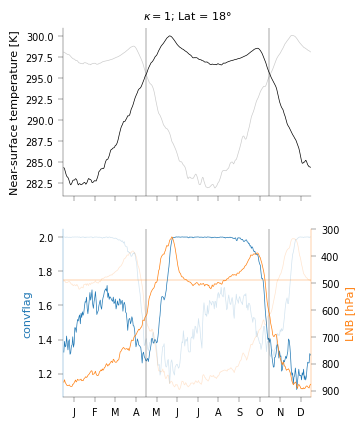

In [6]:
save_summer_def_fig = False

fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 2*width['one_col']/ar), sharex=True)
ax2 = ax[1].twinx()
for i in range(ds_annual_mean.lat.size):
    ax[0].plot(ds_annual_mean.time-0.5, ds_annual_mean.temp[:, i], alpha=0.2 if ds_annual_mean.lat[i]<0 else 1, color='k')
    ax[1].plot(ds_annual_mean.time-0.5, ds_annual_mean.convflag[:, i], color=default_colors[0], alpha=0.2 if ds_annual_mean.lat[i]<0 else 1)
    ax2.plot(ds_annual_mean.time-0.5, lzb(ds_annual_mean.klzbs[:, i]), color=default_colors[1], alpha=0.2 if ds_annual_mean.lat[i]<0 else 1)
for i in range(len(ax)):
    if np.abs(ds_annual_mean.lat[0])>22:
        ax[i].axvline(5*30-1, color='k', lw=ax_linewidth)
        ax[i].axvline(8*30-1, color='k', lw=ax_linewidth)
        ax[i].axvline(11*30-1, color='k', lw=ax_linewidth, alpha=0.2)
        ax[i].axvline(2*30-1, color='k', lw=ax_linewidth, alpha=0.2)
    else:
        ax[i].axvline(4*30-1, color='k', lw=ax_linewidth)
        ax[i].axvline(10*30-1, color='k', lw=ax_linewidth)
ax2.axhline(pressure_ft_actual/100, color=default_colors[1], lw=ax_linewidth)
ax2.invert_yaxis()
ax2.spines[['left', 'bottom']].set_visible(False)
ax2.spines[['right']].set_visible(True)
ax2.spines[['right']].set_color(default_colors[1])
ax[1].spines[['left']].set_color(default_colors[0])
ax[1].set_ylabel('convflag', color=default_colors[0])
ax2.set_ylabel('LNB [hPa]', color=default_colors[1])
ax[0].set_ylabel('Near-surface temperature [K]')
ax[0].set_xlim(-1,360)
ax[0].set_xticks(*month_ticks)
ax[0].set_title(f'$\kappa= {tau_lw[annual_mean_tau_ind]}$; Lat = {round(float(ds_annual_mean.lat[0]))}$\degree$')

if save_fig or save_summer_def_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/summer_definition_lat={annual_mean_lat_plot}.pdf", 
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

## Near Surface Temperature Quantile
Get variables as a function of near-surface temperature quantile

In [7]:
quantiles_all = np.arange(1, 100)
percentile_label = 'Temperature percentile, $x$'
n_quant_all = len(quantiles_all)
n_lat = len(ds_all[0].lat)
n_pressure = ds_all[0].pfull.shape[0]
lat_weights = np.cos(np.deg2rad(ds_all[0].lat))     # latitude area weighting is just the cosine

# Days must have klzb < thresh and convflag > thresh to be considered convecting.
klzb_thresh = 13
convflag_thresh = 1

temp_mean = np.zeros((n_exp, n_pressure, n_lat))         # second index: 0 is surface, 1 is free trop
mse_mod_mean = np.zeros((n_exp, n_lat))
# 2 different methods for computing r_mean and sphum_mean - q calculates from sphum, while r calculates from rh.
sphum_mean = {'q': np.zeros((n_exp, n_lat)), 'r': np.zeros((n_exp, n_lat))}
r_mean = {'q': np.zeros((n_exp, n_lat)), 'r': np.zeros((n_exp, n_lat))}
z_mean = np.zeros((n_exp, n_pressure, n_lat))

lnp_const = R * np.log(p_surface/pressure_ft_actual)/2      # for modified MSE calculation
# as function of temperature quantile
temp_quant3 = np.zeros((n_exp, n_pressure, n_lat, n_quant_all))
mse_mod_quant3 = np.zeros((n_exp, n_lat, n_quant_all))
sphum_quant3 = {'q': np.zeros((n_exp, n_lat, n_quant_all)), 'r': np.zeros((n_exp, n_lat, n_quant_all))}
r_quant3 = {'q': np.zeros((n_exp, n_lat, n_quant_all)), 'r': np.zeros((n_exp, n_lat, n_quant_all))}
z_quant3 = np.zeros((n_exp, n_pressure, n_lat, n_quant_all))
convflag_quant3 = np.zeros((n_exp, n_lat, n_quant_all))
klzbs_quant3 = np.zeros((n_exp, n_lat, n_quant_all))
convfract_quant3 = np.zeros((n_exp, n_lat, n_quant_all))            # record fraction of days convecting
if 'ucomp' in var_keep:
    u_mean = np.zeros((n_exp, n_lat))
    v_mean = np.zeros((n_exp, n_lat))
    u_quant3 = np.zeros((n_exp, n_lat, n_quant_all))
    v_quant3 = np.zeros((n_exp, n_lat, n_quant_all))

with tqdm(total=n_exp*n_lat*n_quant_all, position=0, leave=True) as pbar:
    for i in range(n_exp):
        temp_mean[i] = ds_all[i].temp.mean(dim='lon_time')
        sphum_mean['q'][i] = ds_all[i].sphum.isel(pfull=ind_surf).mean(dim='lon_time')
        z_mean[i] = ds_all[i].height.mean(dim='lon_time')
        # Modify MSE so is one used to compute adiabatic temperature
        mse_mod = moist_static_energy(ds_all[i].temp[ind_surf], ds_all[i].sphum[ind_surf], height=0, c_p_const=c_p - lnp_const)
        mse_mod_mean[i] = mse_mod.mean(dim='lon_time')
        rh_use = ds_all[i].sphum.isel(pfull=ind_surf)/sphum_sat(ds_all[i].temp.isel(pfull=ind_surf), p_surface)
        r_mean['r'][i] = rh_use.mean(dim='lon_time')
        if 'ucomp' in var_keep:
            u_mean[i] = np.abs(ds_all[i].ucomp.isel(pfull=ind_ft)).mean(dim='lon_time')
            v_mean[i] = np.abs(ds_all[i].vcomp.isel(pfull=ind_ft)).mean(dim='lon_time')
        if 'convflag' in var_keep:
            is_convecting = np.logical_and(ds_all[i].klzbs<klzb_thresh, ds_all[i].convflag > convflag_thresh)
        for k in range(n_lat):
            for j, quant in enumerate(quantiles_all):
                use_ind = get_quant_ind(ds_all[i].temp.isel(pfull=ind_surf)[k], quant, 0.5, 0.5)
                sphum_quant3['q'][i, k, j] = ds_all[i].sphum.isel(pfull=ind_surf)[k, use_ind].mean()
                z_quant3[i, :, k, j] = ds_all[i].height[:, k, use_ind].mean(dim='lon_time')
                mse_mod_quant3[i, k, j] = mse_mod[k, use_ind].mean(dim='lon_time')
                temp_quant3[i, :, k, j] = ds_all[i].temp[:, k, use_ind].mean(dim='lon_time')
                r_quant3['r'][i, k, j] = rh_use[k, use_ind].mean(dim='lon_time')
                if 'ucomp' in var_keep:
                    u_quant3[i, k, j] = np.abs(ds_all[i].ucomp[ind_ft, k, use_ind]).mean(dim='lon_time')
                    v_quant3[i, k, j] = np.abs(ds_all[i].vcomp[ind_ft, k, use_ind]).mean(dim='lon_time')
                if 'convflag' in var_keep:
                    convflag_quant3[i, k, j] = ds_all[i].convflag[k, use_ind].mean(dim='lon_time')
                    klzbs_quant3[i, k, j] = ds_all[i].klzbs[k, use_ind].mean(dim='lon_time')
                    convfract_quant3[i, k, j] = np.sum(is_convecting[k, use_ind])/is_convecting[k, use_ind].size
                pbar.update(1)
r_quant3['q'] = sphum_quant3['q'] / sphum_sat(temp_quant3[:, ind_surf], p_surface)
r_mean['q'] = sphum_mean['q'] / sphum_sat(temp_mean[:, ind_surf], p_surface)
sphum_quant3['r'] = sphum_sat(temp_quant3[:, ind_surf], p_surface) * r_quant3['r']
sphum_mean['r'] = sphum_sat(temp_mean[:, ind_surf], p_surface) * r_mean['r']

100%|██████████| 2772/2772 [00:25<00:00, 107.58it/s]


## Different RH and $q$ definitions
Below I illustrate the difference between two definitions of specific humidity and relative humidity:
* $q$ based: I compute the specific humidity as the mean over all days and then find mean relative humidity through: $\overline{r_s} = \overline{q_s}/q^*_s(\overline{T_s})$.
* $r$ based: I compute the relative humidity as the mean over all days (rh on a given day is $q/q^*$ still) and then find the mean specific humidity through: $\overline{q_s} = \overline{r_s}q^*_s(\overline{T_s})$.

The latter seems best as doesn't have problem with very large $\overline{r_s}$.

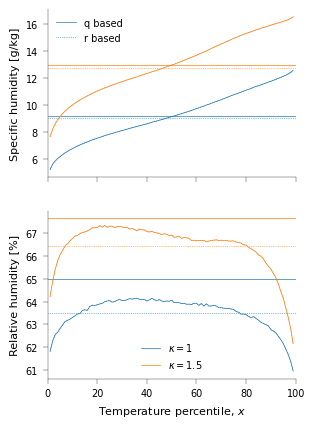

In [8]:
fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 2*width['one_col']/ar), sharex=True)
linestyles_use = {'q': '-', 'r': ':'}
for key in sphum_quant3:
    for i in range(n_exp):
        ax[0].plot(quantiles_all, 1000*np.average(sphum_quant3[key][i], weights=lat_weights, axis=0), 
                   color=default_colors[i], linestyle=linestyles_use[key], label=key + ' based' if i==0 else None)
        ax[0].axhline(1000*np.average(sphum_mean[key][i], weights=lat_weights, axis=0), color=default_colors[i], linestyle=linestyles_use[key])
        ax[1].plot(quantiles_all, 100*np.average(r_quant3[key][i], weights=lat_weights, axis=0), 
                   color=default_colors[i], linestyle=linestyles_use[key], label=f'$\\kappa={tau_lw[i]}$' if key=='q' else None)
        ax[1].axhline(100*np.average(r_mean[key][i], weights=lat_weights, axis=0), color=default_colors[i], linestyle=linestyles_use[key])
ax[0].legend()
ax[1].legend()
ax[1].set_xlabel(percentile_label)
ax[0].set_ylabel('Specific humidity [g/kg]')
ax[1].set_ylabel('Relative humidity [%]')
ax[0].set_xlim([0, 100])
humid_calc = 'r'            # which method to use in rest of notebook - recommend 'r'

In [9]:
print('Max % Deviations From Mean')
print('Temp:', 100*np.abs(np.average((temp_quant3[0, ind_surf]-temp_mean[0, ind_surf, :, np.newaxis])/temp_mean[0, ind_surf, :, np.newaxis], 
                                     axis=0, weights=lat_weights)).max())
for key in r_quant3:
    print(f'RH ({key}):', 100*np.abs(np.average((r_quant3[key][0]-r_mean[key][0, :, np.newaxis])/r_mean[key][0, :, np.newaxis], 
                                                axis=0, weights=lat_weights)).max())

Max % Deviations From Mean
Temp: 2.96163914035211
RH (q): 6.236579446205307
RH (r): 4.0070365548560405


## Relating $z_{FT}$ to $T_{500}$ and $T_s$
A crucial aspect to this theory is relating the geopotential height $z_{FT}$ to near-surface temperature $T$ and free troposphere temperature $T_{FT}$.

We start with two equations, from Zhang 2023. The first combines hydrostatic balance and the ideal gas law. The second assumes a constant lapse rate, $\Gamma$, for integration processes.

$d\ln p = -\frac{g}{RT(p)}dz$;      $z(p) - z_s = \frac{T_s - T(p)}{\Gamma}$

Combining the two, we get $d\ln p = \frac{g}{R\Gamma}d\ln T$.

Integrating between the free troposphere at 500hPa and surface at 1000hPa, we get:
$\ln(\frac{1000}{500}) = \ln 2 = \frac{g}{R\Gamma}\ln(\frac{T_s}{T_{500}})$ or $\frac{1}{\Gamma} = \frac{R\ln 2}{g\ln(\frac{T_s}{T_{500}})}$

We also have the $z$ equation applied at 500hPa: $z_{500} - z_s = \frac{T_s - T_{500}}{\Gamma}$. Combining the two, we get:
$z_{500} - z_s \approx \frac{R\ln 2(T_s - T_{500})}{g\ln(\frac{T_s}{T_{500}})}$

We can re-write the denominator in $\ln(1+x)$ form as $\ln(1+\frac{T_s-T_{500}}{T_{500}})$. Here $x=\frac{T_s-T_{500}}{T_{500}}$ and is small. Max value in tropics is about 0.15. 

The taylor series is $\frac{1}{\ln(1+x)} \approx \frac{1}{x} + \frac{1}{2} - \frac{x}{12} + ...$. Because $x$ is small, I propose keeping just the first two terms. In which case, we get:

$z_{500} - z_s \approx \frac{R\ln 2(T_s - T_{500})}{g}(\frac{T_{500}}{T_s-T_{500}} + \frac{1}{2}) = \frac{R\ln 2}{2g}(T_s + T_{500})$

The plots below shows that the taylor approximation is pretty accurate, and they are both decent approximations for the actual geopotential height.

In [10]:
def get_z_theory(temp_surf, temp_ft, taylor=True, pressure_surf=p_surface, pressure_ft=pressure_ft_actual):
    lnp_prefactor = R * np.log(pressure_surf/pressure_ft) / g
    if taylor:
        return lnp_prefactor/2 * (temp_surf + temp_ft)
    else:
        return lnp_prefactor * (temp_surf - temp_ft) / np.log(temp_surf/temp_ft)

z_theory_quant3 = {key: np.zeros((n_exp, n_lat, n_quant_all)) for key in ['full', 'taylor']}
z_theory_mean = {key: np.zeros((n_exp, n_lat)) for key in ['full', 'taylor']}
for i in range(n_exp):
    for key in z_theory_quant3:
        z_theory_quant3[key][i] = get_z_theory(temp_quant3[i, ind_surf], temp_quant3[i, ind_ft], True if key=='taylor' else False)
        z_theory_mean[key][i] = get_z_theory(temp_mean[i, ind_surf], temp_mean[i, ind_ft], True if key=='taylor' else False)

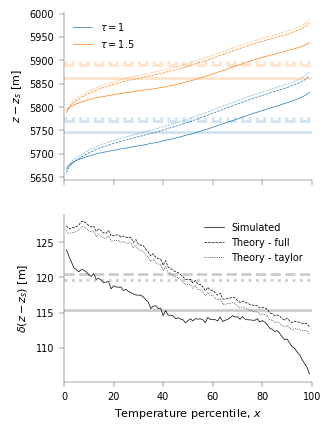

In [11]:
save_z_ft_fig = False
fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 2*width['one_col']/ar), sharex=True)
linestyles_use = {'full': '--', 'taylor': ':'}
for i in range(n_exp):
    ax[0].plot(quantiles_all, 
               np.average(z_quant3[i, ind_ft] - z_quant3[i, ind_surf], axis=0, weights=lat_weights), color=default_colors[i],
               label=f'$\\tau={tau_lw[i]}$')
    ax[0].axhline(np.average(z_mean[i, ind_ft]-z_mean[i, ind_surf], axis=0, weights=lat_weights), color=default_colors[i], lw=2, alpha=0.2)
    for key in z_theory_quant3:
        ax[0].plot(quantiles_all, 
                   np.average(z_theory_quant3[key][i], axis=0, weights=lat_weights), color=default_colors[i], 
                   linestyle=linestyles_use[key])
        ax[0].axhline(np.average(z_theory_mean[key][i], axis=0, weights=lat_weights), color=default_colors[i], 
                      linestyle=linestyles_use[key], lw=2, alpha=0.2)
ax[1].plot(quantiles_all, 
           np.average(np.diff(z_quant3[:, ind_ft] - z_quant3[:, ind_surf], axis=0)[0], axis=0, weights=lat_weights), color='k',
           label='Simulated')
ax[1].axhline(np.average(np.diff(z_mean[:, ind_ft]-z_mean[:, ind_surf], axis=0)[0], axis=0, weights=lat_weights), 
              color='k', lw=2, alpha=0.2)
for key in z_theory_quant3:
    ax[1].plot(quantiles_all, 
                   np.average(z_theory_quant3[key][1]-z_theory_quant3[key][0], axis=0, weights=lat_weights), 
               color='k', linestyle=linestyles_use[key], label=f'Theory - {key}')
    ax[1].axhline(np.average(z_theory_mean[key][1]-z_theory_mean[key][0], axis=0, weights=lat_weights), color='k', 
                  linestyle=linestyles_use[key], lw=2, alpha=0.2)
ax[0].legend()
ax[1].legend()
ax[0].set_ylabel('$z-z_s$ [m]')
ax[1].set_ylabel('$\delta (z-z_s)$ [m]')
ax[1].set_xlabel(percentile_label)
ax[0].set_xlim(0, 100)
if save_fig or save_z_ft_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/z_ft_approx_{region}_{season}.pdf",
                                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

### $z$ Anomaly
The plot below is the same as above but for the anomaly i.e. $\Delta z = z(x) - \overline{z}$. This is what turns up in the later equations so makes sense to plot it as well.

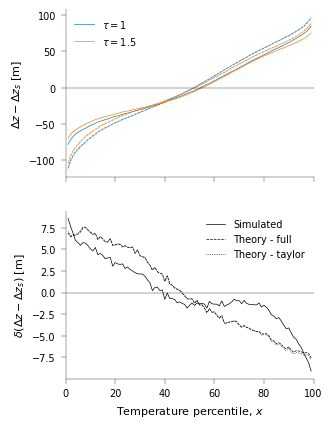

In [12]:
save_z_ft_anom_fig = False
fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 2*width['one_col']/ar), sharex=True)
linestyles_use = {'full': '--', 'taylor': ':'}
for i in range(n_exp):
    ax[0].plot(quantiles_all, 
               np.average(z_quant3[i, ind_ft] - z_quant3[i, ind_surf] - (z_mean[i, ind_ft]-z_mean[i, ind_surf])[:, np.newaxis], 
                          axis=0, weights=lat_weights), color=default_colors[i], label=f'$\\tau={tau_lw[i]}$')
    for key in z_theory_quant3:
        ax[0].plot(quantiles_all, 
                   np.average(z_theory_quant3[key][i] - z_theory_mean[key][i][:, np.newaxis], axis=0, weights=lat_weights),
                   color=default_colors[i], linestyle=linestyles_use[key])
ax[1].plot(quantiles_all, 
           np.average(np.diff(z_quant3[:, ind_ft] - z_quant3[:, ind_surf] - (z_mean[:, ind_ft]-z_mean[:, ind_surf])[:, :, np.newaxis],
                              axis=0)[0], axis=0, weights=lat_weights), color='k', label='Simulated')
for key in z_theory_quant3:
    ax[1].plot(quantiles_all, 
                   np.average(np.diff(z_theory_quant3[key] - z_theory_mean[key][:, :, np.newaxis], axis=0)[0], 
                              axis=0, weights=lat_weights), color='k', linestyle=linestyles_use[key], label=f'Theory - {key}')
ax[0].axhline(0, color='k', lw=ax_linewidth)
ax[1].axhline(0, color='k', lw=ax_linewidth)
ax[0].legend()
ax[1].legend()
ax[0].set_ylabel('$\Delta z- \Delta z_s$ [m]')
ax[1].set_ylabel('$\delta (\Delta z- \Delta z_s)$ [m]')
ax[1].set_xlabel(percentile_label)
ax[0].set_xlim(0, 100)
if save_fig or save_z_ft_anom_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/z_ft_anom_approx_{region}_{season}.pdf",
                                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

In [13]:
if 'ucomp' in var_keep:
    fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 2*width['one_col']/ar), sharex=True)
    for i in range(n_exp):
        ax[0].plot(quantiles_all, np.average(u_quant3[i]-u_mean[i][:, np.newaxis], axis=0, weights=lat_weights), 
                   color=default_colors[i], label=f'$\\tau={tau_lw[i]}$')
        ax[0].plot(quantiles_all, np.average(v_quant3[i]-v_mean[i][:, np.newaxis], axis=0, weights=lat_weights), color=default_colors[i], linestyle=':')
    ax[1].plot(quantiles_all, np.average(np.diff(u_quant3-u_mean[:, :, np.newaxis], axis=0)[0], axis=0, weights=lat_weights), color='k',
               label='$u$')
    ax[1].plot(quantiles_all, np.average(np.diff(v_quant3-v_mean[:, :, np.newaxis], axis=0)[0], axis=0, weights=lat_weights), 
               color='k', linestyle=':', label='$v$')
    ax[0].axhline(0, color='k', lw=ax_linewidth)
    ax[1].axhline(0, color='k', lw=ax_linewidth)
    ax[0].legend()
    ax[1].legend()
    ax[0].set_ylabel('$\Delta u$ [m]')
    ax[1].set_ylabel('$\delta \Delta u$ [m]')
    ax[1].set_xlabel(percentile_label)
    ax[0].set_xlim(0, 100)

## Adiabatic Temperature

The starting point for the original theory is the assumption that $\delta h(x) \approx \delta \overline{h}$.

We can define an adiabatic temperature, $T_{A, 500}$, such that the saturated free troposphere MSE is equal to the near-surface MSE:
$h(x) = c_pT_s + L_v q + g z_s = c_p T_{A, 500} + L_vq^*(T_{A, 500}) + gz_{A, 500}$.

Using the above approximation, we can sub in for $z_{A,500} - z_s \approx \frac{R\ln 2}{2g}(T_s + T_{A, 500})$ to get:
$h^{\dagger} = (c_p - \frac{R\ln 2}{2})T_s + L_v q = (c_p + \frac{R\ln 2}{2})T_{A, 500} + L_vq^*(T_{A, 500})$ 

Similarly, in the mean we have $\overline{h^{\dagger}} = (c_p + \frac{R\ln 2}{2})\overline{T_{A, 500}} + L_vq^*(\overline{T_{A, 500}})$

Where we have defined the modified moist static energy, $h^{\dagger} = h - \frac{R\ln 2}{2}T - gz$

Below, we solve these two equations to get estimates of $T_A(x)$ and $\overline{T_A}$ (dropping the 500hPa indicator).

The figure below is just a sanity check to ensure the equality of the two moist static energy like quantities. It also shows that $T_A$ differs from the actual free troposphere temperature. The different colours refer to the different simulations as usual.

In [14]:
temp_adiabat_mean = np.zeros((n_exp, n_lat))
temp_adiabat_quant3 = np.zeros((n_exp, n_lat, n_quant_all))
for i in range(n_exp):
    for j in range(n_lat):
        temp_adiabat_mean[i, j] = get_temp_adiabat(temp_mean[i, ind_surf, j], sphum_mean[humid_calc][i, j], p_surface, pressure_ft_actual)
        for k in range(n_quant_all):
            temp_adiabat_quant3[i, j, k] = get_temp_adiabat(temp_quant3[i, ind_surf, j, k], sphum_quant3[humid_calc][i, j, k], 
                                                            p_surface, pressure_ft_actual)

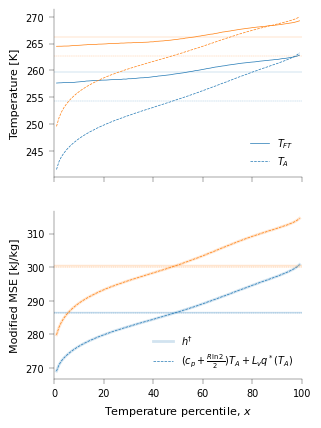

In [15]:
save_mse_ft_fig = False
fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 2*width['one_col']/ar), sharex=True)
for i in range(n_exp):
    ax[0].plot(quantiles_all, 
            np.average(temp_quant3[i, ind_ft], axis=0, weights=lat_weights), color=default_colors[i], label='$T_{FT}$' if i==0 else None)
    ax[0].plot(quantiles_all, 
            np.average(temp_adiabat_quant3[i], axis=0, weights=lat_weights), color=default_colors[i], linestyle='--', 
               label='$T_A$' if i==0 else None)
    ax[0].axhline(np.average(temp_mean[i, ind_ft], axis=0, weights=lat_weights), color=default_colors[i], lw=ax_linewidth, alpha=0.6)
    ax[0].axhline(np.average(temp_adiabat_mean[i], axis=0, weights=lat_weights), color=default_colors[i], lw=ax_linewidth, alpha=0.6,
                  linestyle='--')
    ax[1].plot(quantiles_all, np.average(mse_mod_quant3[i], axis=0, weights=lat_weights), color=default_colors[i], 
               lw=2, alpha=0.2, label='$h^{\dagger}$' if i==0 else None)
    ax[1].plot(quantiles_all, np.average(moist_static_energy(temp_adiabat_quant3[i], sphum_sat(temp_adiabat_quant3[i], pressure_ft_actual),
                                                             height=0, c_p_const=c_p + lnp_const), axis=0, weights=lat_weights),
               color=default_colors[i], linestyle='--', label='$(c_p + \\frac{R\ln 2}{2})T_{A} + L_vq^*(T_{A})$' if i==0 else None)
    ax[1].axhline(np.average(mse_mod_mean[i], axis=0, weights=lat_weights), color=default_colors[i], 
               lw=1, alpha=0.2)
    ax[1].axhline(np.average(moist_static_energy(temp_adiabat_mean[i], sphum_sat(temp_adiabat_mean[i], pressure_ft_actual),
                                                 height=0, c_p_const=c_p + lnp_const), axis=0, weights=lat_weights), 
                  color=default_colors[i], linestyle='--', lw=ax_linewidth)
ax[0].legend()
ax[1].legend()
ax[0].set_ylabel('Temperature [K]')
ax[1].set_ylabel('Modified MSE [kJ/kg]')
ax[1].set_xlabel(percentile_label)
ax[0].set_xlim(0, 100)
if save_fig or save_mse_ft_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/mse_ft_sat_{region}_{season}.pdf",
                                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

## Extended Theory
Doing a taylor expansion of $h^{\dagger}(x)$ for a given simulation about $\overline{T_A}$ we get:
$h^{\dagger}(x) \approx (c_p+\frac{R\ln 2}{2}) \overline{T_A} + L_v q^*(\overline{T_A}) + (c_p + \frac{R\ln 2}{2} + L_v \alpha(\overline{T_A}) q^*(\overline{T_A}))\Delta T_A$

Using the definition of $\overline{h^{\dagger}}$, this becomes:
$h^{\dagger}(x)-\overline{h^{\dagger}} \approx (c_p + \frac{R\ln 2}{2} + L_v \alpha q^*)\Delta T_A$

This is shown by the dashed lines in the top plot of the second figure below. The dotted lines include the squared term in the expansion.

Taking the difference between simulations:
$\delta (h^{\dagger}(x)-\overline{h^{\dagger}}) \approx \beta_1 \delta \Delta T_A + \beta_2\frac{\Delta T_A}{\overline{T_A}}\delta \overline{T_A}$
where $\beta_1 = \frac{d\overline{h^{\dagger}}}{d\overline{T_A}} = c_p + \frac{R\ln 2}{2} + L_v \alpha q^*$ and $\beta_2 = \overline{T_A}\frac{d\beta_1}{d\overline{T_A}} = L_v \alpha q^*(\alpha \overline{T_A} - 2)$

From the equation for $\overline{h^{\dagger}}$, we have $\delta \overline{T_A} \approx \frac{\delta \overline{h^{\dagger}}}{\beta_1}$. This is shown in the first plot below with the exact $\delta \overline{h^{\dagger}}$.

Combining everything, we have:
$$\delta (h^{\dagger}(x)-\overline{h^{\dagger}}) \approx \beta_1 \delta \Delta T_A + \frac{\beta_2}{\beta_1}\frac{\Delta T_A}{\overline{T_A}}\delta \overline{h^{\dagger}}$$

This is shown by the thick red line in the bottom plot of the second figure below. The dotted red line includes squared terms in this equation. The black lines show just take the difference of the respective coloured lines in the plot above. The red dashed line should be the same as the red thick line - same equation used by different functions, really just a sanity check.

In [16]:
def get_h_anom_theory(temp_adiabat_mean, temp_adiabat_quant, p_ft = pressure_ft_actual,
                      include_squared_term=False):
    """
        Get h - h_mean theory using taylor expansion and free troposphere adiabatic temperatures.
    Args:
        temp_adiabat_mean: float
        temp_adiabat_quant: [n_quant]
        p_ft: float
        include_squared_term: bool

    Returns:
        [n_quant]
            MSE anomaly in kJ/kg
    """
    temp_adiabat_anom = temp_adiabat_quant - temp_adiabat_mean
    alpha_mean = clausius_clapeyron_factor(temp_adiabat_mean, p_ft)
    q_sat_mean = sphum_sat(temp_adiabat_mean, p_ft)
    if include_squared_term:
        squared_term = 0.5 * L_v * alpha_mean * q_sat_mean / temp_adiabat_mean * (alpha_mean * temp_adiabat_mean - 2) * temp_adiabat_anom**2
    else:
        squared_term = 0
    return ((c_p + lnp_const) * temp_adiabat_anom + L_v * q_sat_mean * alpha_mean * temp_adiabat_anom + squared_term)/1000

def get_delta_temp_adiabat_mean_theory(temp_adiabat_mean, mse_surf_mean, 
                                       temp_surf_mean = None, sphum_surf_mean = None, p_ft=pressure_ft_actual, p_surface=p_surface, 
                                       include_squared_term=False):
    """
    Assumes n_exp=2
    Args:
        temp_adiabat_mean: [n_exp]
        kappa_mean: [n_exp]
        mse_surf_mean: [n_exp]
            In units of kJ/kg
            If given, computes the exact difference in MSE surface. Otherwise, does linear expansion with temp_surf and sphum_surf.
        temp_surf_mean: [n_exp]
        sphum_surf_mean: [n_exp]
        p_ft: float (Pa)
        p_surface: float (Pa)
        include_squared_term: bool
            If `True`, will include squared terms in taylor expansion

    Returns:
        float
    """
    if mse_surf_mean is not None:
        delta_mse = (mse_surf_mean[1] - mse_surf_mean[0]) * 1000        # convert into units of J/kg
    else:
        # Do linear taylor expansion to compute delta_mse if actual value not given
        delta_rh = float(np.diff(sphum_surf_mean / sphum_sat(temp_surf_mean, p_surface)))
        delta_temp_surf = temp_surf_mean[1] - temp_surf_mean[0]
        alpha_surf = clausius_clapeyron_factor(temp_surf_mean[0], p_surface)
        q_sat_surf = sphum_sat(temp_surf_mean[0], p_surface)
        delta_mse = (c_p + L_v * sphum_surf_mean[0] * alpha_surf) * delta_temp_surf + L_v * q_sat_surf * delta_rh
    alpha = clausius_clapeyron_factor(temp_adiabat_mean[0], p_ft)
    q_sat = sphum_sat(temp_adiabat_mean[0], p_ft)
    
    beta_1 = c_p + lnp_const + L_v * alpha * q_sat                        # this is a float
    beta_2 = L_v * alpha * q_sat * (alpha * temp_adiabat_mean[0] - 2)   # this is a float, same units as beta
    final_answer = delta_mse/beta_1
    if include_squared_term:
        final_answer = final_answer - 0.5 * beta_2/(beta_1**3 * temp_adiabat_mean[0]) * delta_mse**2
    return final_answer

In [17]:
delta_temp_adiabat_mean = {'simulated': temp_adiabat_mean[1]-temp_adiabat_mean[0], 
                           'linear': np.zeros(n_lat), 'squared': np.zeros(n_lat)}
h_anom_theory = {'linear': np.zeros((n_exp, n_lat, n_quant_all)), 'squared': np.zeros((n_exp, n_lat, n_quant_all))}
delta_h_anom = {'simulated': np.diff(mse_mod_quant3 - mse_mod_mean[:, :, np.newaxis], axis=0)[0], 
                'linear': np.zeros((n_lat, n_quant_all)), 'squared': np.zeros((n_lat, n_quant_all))}
delta_h_anom_theory_prefactors = {key: np.zeros((n_lat, n_quant_all)) for key in 
                           ['temp_adiabat_anom', 'mse_mod_mean', 'mse_mod_mean_squared', 'non_linear']}
delta_h_anom_theory_prefactors = {key: copy.deepcopy(delta_h_anom_theory_prefactors) for key in ['linear', 'squared', 'simple']}
delta_h_anom_theory_diff = copy.deepcopy(delta_h_anom_theory_prefactors)
delta_h_anom_theory_cont = copy.deepcopy(delta_h_anom_theory_prefactors)

for j in range(n_lat):
    for key in ['linear', 'squared']:
        delta_temp_adiabat_mean[key][j] = \
            get_delta_temp_adiabat_mean_theory(temp_adiabat_mean[:, j], mse_mod_mean[:, j], 
                                               temp_mean[:, ind_surf, j], sphum_mean[humid_calc][:, j], 
                                               include_squared_term=True if key=='squared' else False)
        delta_h_anom[key][j], info = get_delta_mse_mod_anom_theory(temp_mean[:, ind_surf, j], temp_quant3[:, ind_surf, j], sphum_mean[humid_calc][:, j],
                                                                   sphum_quant3[humid_calc][:, j], p_surface, pressure_ft_actual, 
                                                                   taylor_terms=key)[:2]
        for info_key in delta_h_anom_theory_prefactors['squared']:
            delta_h_anom_theory_prefactors[key][info_key][j] = info[info_key][0]
            delta_h_anom_theory_diff[key][info_key][j] = info[info_key][1]
            delta_h_anom_theory_cont[key][info_key][j] = delta_h_anom_theory_prefactors[key][info_key][j] * \
                                                         delta_h_anom_theory_diff[key][info_key][j]
    for i in range(n_exp):
        for key in h_anom_theory:
            h_anom_theory[key][i, j] = get_h_anom_theory(temp_adiabat_mean[i, j], temp_adiabat_quant3[i, j], 
                                                         include_squared_term=True if key=='squared' else False)

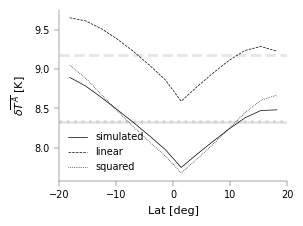

In [18]:
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
linestyles_use = ['-', '--', ':']
for i, key in enumerate(delta_temp_adiabat_mean):
    ax.plot(ds_all[0].lat, delta_temp_adiabat_mean[key], color='k', label=key, linestyle=linestyles_use[i])
    ax.axhline(np.average(delta_temp_adiabat_mean[key], weights=lat_weights, axis=0), color='k', 
               linestyle=linestyles_use[i], lw=2, alpha=0.1)
ax.set_xlim(-lat_max, lat_max)
ax.set_ylabel('$\delta \overline{T^A}$ [K]')
ax.set_xlabel('Lat [deg]')
ax.legend()
plt.tight_layout()

Below, the linear red line captures the broad trend we are after.

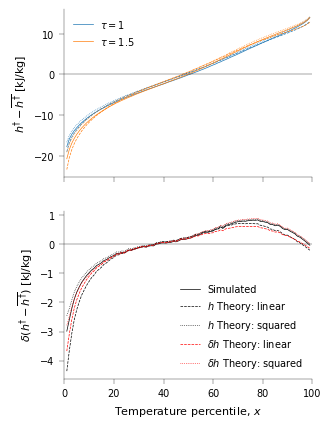

In [19]:
save_mse_anom_fig = False
fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 2*width['one_col']/ar), sharex=True)
for i in range(n_exp):
    ax[0].plot(quantiles_all, 
               np.average(mse_mod_quant3[i] - mse_mod_mean[i][:, np.newaxis], axis=0, weights=lat_weights),
               color=default_colors[i], label=f'$\\tau={tau_lw[i]}$')
    ax[0].plot(quantiles_all, 
               np.average(h_anom_theory['linear'][i], axis=0, weights=lat_weights),
               color=default_colors[i], linestyle='--')
    ax[0].plot(quantiles_all, 
               np.average(h_anom_theory['squared'][i], axis=0, weights=lat_weights),
               color=default_colors[i], linestyle=':')
ax[1].plot(quantiles_all, np.average(delta_h_anom['simulated'], 
                                     axis=0, weights=lat_weights), color='k', label='Simulated')
ax[1].plot(quantiles_all, np.average(np.diff(h_anom_theory['linear'], axis=0)[0], axis=0, weights=lat_weights), 
           color='k', linestyle='--', label='$h$ Theory: linear')
ax[1].plot(quantiles_all, np.average(np.diff(h_anom_theory['squared'], axis=0)[0], axis=0, weights=lat_weights), 
           color='k', linestyle=':', label='$h$ Theory: squared')
ax[1].plot(quantiles_all, np.average(delta_h_anom['linear'], axis=0, weights=lat_weights), 
           color='r', linestyle='--', label='$\delta h$ Theory: linear')
ax[1].plot(quantiles_all, np.average(delta_h_anom['squared'], axis=0, weights=lat_weights), 
           color='r', linestyle=':', label='$\delta h$ Theory: squared')
ax[0].axhline(0, color='k', lw=ax_linewidth)
ax[1].axhline(0, color='k', lw=ax_linewidth)
ax[0].legend()
ax[1].legend()
ax[0].set_ylabel('$h^{\dagger}-\overline{h^{\dagger}}$ [kJ/kg]')
ax[1].set_ylabel('$\delta (h^{\dagger}-\overline{h^{\dagger}})$ [kJ/kg]')
ax[1].set_xlabel(percentile_label)
ax[0].set_xlim(0, 100)

if save_fig or save_mse_anom_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/mse_anom_{region}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

## Breakdown of $\delta (h^{\dagger}(x) - \overline{h^{\dagger}})$ contributions
Below I show which terms are most important in explaining why $\lambda \neq 1$.

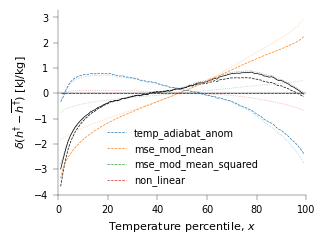

In [20]:
save_mse_anom_theory_decomp_fig = False
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar), sharex=True)
ax.plot(quantiles_all, np.average(delta_h_anom['simulated'], 
                                     axis=0, weights=lat_weights), color='k')
ax.plot(quantiles_all, np.average(delta_h_anom['linear'], axis=0, weights=lat_weights), 
           color='k', linestyle='--')
ax.plot(quantiles_all, np.average(delta_h_anom['squared'], axis=0, weights=lat_weights), 
           color='k', linestyle=':', alpha=0.5)
for i, key in enumerate(delta_h_anom_theory_cont['linear']):
    ax.plot(quantiles_all, np.average(delta_h_anom_theory_cont['linear'][key], axis=0, weights=lat_weights), 
            color=default_colors[i], label=key, linestyle='--')
    ax.plot(quantiles_all, np.average(delta_h_anom_theory_cont['squared'][key], axis=0, weights=lat_weights), 
            color=default_colors[i], linestyle=':', alpha=0.5)
ax.legend()
ax.axhline(0, color='k', lw=ax_linewidth)
ax.set_ylabel('$\delta (h^{\dagger}-\overline{h^{\dagger}})$ [kJ/kg]')
ax.set_xlabel(percentile_label)
ax.set_xlim(0, 100)

if save_fig or save_mse_anom_theory_decomp_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/mse_anom_theory_decomp_{region}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

## Climatological $\Delta T_A$ Breakdown
The variation in the $\delta \overline{h}$ contribution is caused by the variation of $\Delta T^A(x)$ with $x$ in the current climate.
We can decompose this into a WTG and two Convective Equilibrium (CE) terms:
$\Delta T_{WTG}(x) = T_{FT}(x) - \overline{T_{FT}}$
$\Delta T_{CE}(x) = T_{FT}(x) - T^A_{FT}(x)$
$\Delta \overline{T_{CE}} = \overline{T_{FT}} - \overline{T^A_{FT}}$

Putting everything together, we have:
$\Delta T^A(x) = T^A_{FT}(x) - \overline{T^A_{FT}} = \Delta T_{WTG}(x) - \Delta T_{CE}(x) + \Delta \overline{T_{CE}}$

If WTG and CE were both valid in the current climate, then clearly $\Delta T^A(x) = 0$ and the `mse_mean` term in the above plot would be 0.

Equally, we can decompose the change in the anomaly with warming, $\delta \Delta T^A(x)$:
$\delta (\Delta T^A(x)) = \delta (T^A_{FT}(x) - \overline{T^A_{FT}}) = \delta (\Delta T_{WTG}(x)) - \delta(\Delta T_{CE}(x)) + \delta(\Delta \overline{T_{CE}})$

In convective-quasi equilibrium, we would expect $\delta(\Delta T_{CE}(x)) \approx \delta(\Delta \overline{T_{CE}}) \approx 0$. If WTG remained valid, we would expect $\delta (\Delta T_{WTG}(x)) \approx 0$. Together, they would give $\delta (\Delta T^A(x)) \approx 0$.

It seems that WTG is pretty well satisfied, and the main trend comes from the convection part.
If convection becomes more prevalent on all days that are not yet convecting, the climatological $\Delta T_{CE}$ and the change $\delta \Delta T_{CE}$ oppose each other. This happens for small $x$.

If a climate is convecting i.e. $\Delta T_{CE} < 0$ and CAPE increases with warming i.e. $\delta \Delta T_{CE} < 0$ then they reinforce each other. This happens at large $x$.

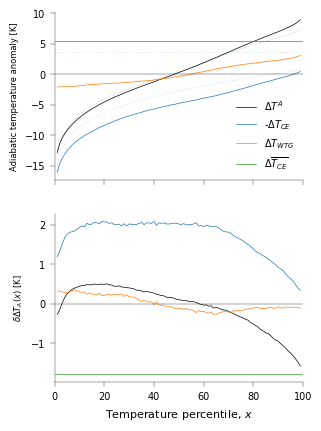

In [21]:
temp_adiabat_anom = np.zeros((n_exp, n_lat, n_quant_all))
temp_ce_mean_anom = np.zeros((n_exp, n_lat))
temp_ce_quant = np.zeros((n_exp, n_lat, n_quant_all))
temp_wtg_anom = np.zeros((n_exp, n_lat, n_quant_all))
for j in range(n_lat):
    temp_adiabat_anom[:, j], temp_ce_mean_anom[:, j], temp_ce_quant[:, j], temp_wtg_anom[:, j] = \
        decompose_temp_adiabat_anomaly(temp_mean[:, ind_surf, j], temp_quant3[:, ind_surf, j], sphum_mean[humid_calc][:, j], 
                                       sphum_quant3[humid_calc][:, j], 
                                       temp_mean[:, ind_ft, j], temp_quant3[:, ind_ft, j], p_surface, pressure_ft_actual)

save_temp_adiabat_anom_fig = False
fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 2*width['one_col']/ar), sharex=True)
linestyles_use = ['-', ':']
alpha_use = [1, 0.3]
for i in range(n_exp):
    ax[0].plot(quantiles_all, np.average(temp_adiabat_anom[i], weights=lat_weights, axis=0), color='k', 
               label='$\Delta T^A$' if i==0 else None, linestyle=linestyles_use[i], alpha=alpha_use[i])
    ax[0].plot(quantiles_all, -np.average(temp_ce_quant[i], weights=lat_weights, axis=0), color=default_colors[0], 
               label='-$\Delta T_{CE}$' if i==0 else None, linestyle=linestyles_use[i], alpha=alpha_use[i])
    ax[0].plot(quantiles_all, np.average(temp_wtg_anom[i], weights=lat_weights, axis=0), color=default_colors[1], 
               label='$\Delta T_{WTG}$' if i==0 else None, linestyle=linestyles_use[i], alpha=alpha_use[i])
    ax[0].axhline(np.average(temp_ce_mean_anom[i], weights=lat_weights, axis=0), color=default_colors[2], 
                  label='$\Delta \overline{T_{CE}}$' if i==0 else None, linestyle=linestyles_use[i], alpha=alpha_use[i])
ax[1].plot(quantiles_all, np.average(temp_adiabat_anom[1]-temp_adiabat_anom[0], weights=lat_weights, axis=0), color='k')
ax[1].plot(quantiles_all, -np.average(temp_ce_quant[1]-temp_ce_quant[0], weights=lat_weights, axis=0), color=default_colors[0])
ax[1].plot(quantiles_all, np.average(temp_wtg_anom[1] - temp_wtg_anom[0], weights=lat_weights, axis=0), color=default_colors[1])
ax[1].axhline(np.average(temp_ce_mean_anom[1]-temp_ce_mean_anom[0], weights=lat_weights, axis=0), color=default_colors[2])
ax[0].axhline(0, color='k', lw=ax_linewidth)
ax[1].axhline(0, color='k', lw=ax_linewidth)
ax[0].legend()
ax[1].set_xlabel(percentile_label)
ax[0].set_xlim(0, 100)
ax[0].set_ylabel('Adiabatic temperature anomaly [K]', fontsize=6)
ax[1].set_ylabel('$\delta \Delta T_A(x)$ [K]', fontsize=6)

if save_fig or save_temp_adiabat_anom_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/temp_adiabat_anom_{region}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

Below is basically a repeat of the above, but I include the prefactors in the linear $\delta (h^{\dagger}(x)-\overline{h^{\dagger}})$ theory so the actual magnitudes can be compared.

In the non-linear case, you get cross terms so it doesn't make much sense.

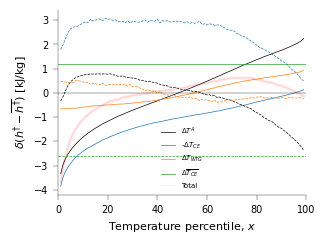

In [22]:
save_mse_anom_decomp_fig = False
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar), sharex=True)
ax.plot(quantiles_all, np.average(delta_h_anom_theory_cont['linear']['mse_mod_mean'], weights=lat_weights, axis=0), 
        color='k', label='$\Delta T^A$')
prefactor_use = delta_h_anom_theory_cont['linear']['mse_mod_mean'] / temp_adiabat_anom[0]      # [n_lat, n_quant] but same for each quant
ax.plot(quantiles_all, -np.average(prefactor_use * temp_ce_quant[0], weights=lat_weights, axis=0), 
        color=default_colors[0], label='-$\Delta T_{CE}$')
ax.plot(quantiles_all, np.average(prefactor_use * temp_wtg_anom[0], weights=lat_weights, axis=0), 
        color=default_colors[1], label='$\Delta T_{WTG}$')
ax.axhline(np.average(prefactor_use[:, 0] * temp_ce_mean_anom[0], weights=lat_weights, axis=0), color=default_colors[2], 
           label='$\Delta \overline{T_{CE}}$')
prefactor_use = delta_h_anom_theory_prefactors['linear']['temp_adiabat_anom']
ax.plot(quantiles_all, np.average(delta_h_anom_theory_cont['linear']['temp_adiabat_anom'], weights=lat_weights, axis=0), 
        color='k', linestyle='--')
ax.plot(quantiles_all, -np.average(prefactor_use * (temp_ce_quant[1]-temp_ce_quant[0]), weights=lat_weights, axis=0), 
        color=default_colors[0], linestyle='--')
ax.plot(quantiles_all, np.average(prefactor_use * (temp_wtg_anom[1]-temp_wtg_anom[0]), weights=lat_weights, axis=0), 
        color=default_colors[1], linestyle='--')
ax.axhline(np.average(prefactor_use[:, 0] * (temp_ce_mean_anom[1]-temp_ce_mean_anom[0]), weights=lat_weights, axis=0), 
           color=default_colors[2], linestyle='--')
ax.plot(quantiles_all, np.average(delta_h_anom_theory_cont['linear']['mse_mod_mean'] + delta_h_anom_theory_cont['linear']['temp_adiabat_anom'],
                                  weights=lat_weights, axis=0), color='r', lw=2, alpha=0.1)
ax.plot(quantiles_all, np.average(delta_h_anom['linear'], weights=lat_weights, axis=0), color='r', alpha=0.1, label='Total')
ax.axhline(0, color='k', lw=ax_linewidth)
ax.legend(fontsize=5)
ax.set_ylabel('$\delta (h^{\dagger}-\overline{h^{\dagger}})$ [kJ/kg]')
ax.set_xlabel(percentile_label)
ax.set_xlim(0, 100)

if save_fig or save_mse_anom_decomp_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/mse_anom_decomp_{region}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

### Conversion between $\Delta T_{WTG}$ and $\Delta z$
For the extratropics, we know WTG is not valid, so we want to consider geopotential height instead i.e. $\Delta z = z(x) - \overline{z}$. Below, we see how we can convert between the two terms.

We can start with our equation for $z$: $z_{FT}(x) - z_s(x) \approx \frac{R\ln 2}{2g}(T_s(x) + T_{FT}(x))$ and $\overline{z_{FT}} - \overline{z_s} \approx \frac{R\ln 2}{2g}(\overline{T_s} + \overline{T_{FT}})$

Subtracting the two, we have:
$\Delta z - (z_s - \overline{z_s}) \approx \frac{R\ln 2}{2g}(T_s - \overline{T_s} + \Delta T_{WTG})$

Rearranging, we get an equation for $\Delta T_{WTG}$:
$\Delta T_{WTG} \approx \frac{2g}{R\ln 2}(\Delta z - \Delta z_s) - \Delta T_s$

Taking the difference between simulations, we get:
$\delta \Delta T_{WTG} \approx \frac{2g}{R\ln 2}(\delta \Delta z - \delta \Delta z_s) - \delta \Delta T_s$

In the second plot below, we see that this theory differs quite a lot from the simulated $\Delta T_{WTG}$. This is because of the intitial $z$ approximate equation. I.e. this plot and the $\Delta z$ plot earlier look very similar, just shifted by the $\Delta T_s$ term.

It is clear that we can neglect the $\Delta z_s$ terms though.

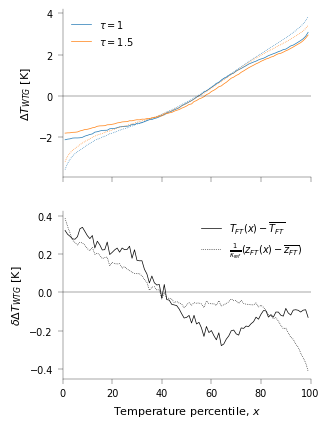

In [23]:
save_wtg_fig = False
fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 2*width['one_col']/ar), sharex=True)
scale_factor = temp_mean[0, ind_ft] / z_mean[0, ind_ft]         # to put z on same axis as temp
for i in range(n_exp):
    ax[0].plot(quantiles_all, np.average(temp_quant3[i, ind_ft] - temp_mean[i, ind_ft][:, np.newaxis], weights=lat_weights, axis=0),
            color=default_colors[i], label=f'$\\tau={tau_lw[i]}$')
    ax[0].plot(quantiles_all, 
            np.average(scale_factor[:, np.newaxis] * (z_quant3[i, ind_ft] - z_mean[i, ind_ft][:, np.newaxis]), 
                       weights=lat_weights, axis=0), color=default_colors[i], linestyle=':')
ax[1].plot(quantiles_all, np.average(np.diff(temp_quant3[:, ind_ft] - temp_mean[:, ind_ft, :, np.newaxis], axis=0)[0],
                                     weights=lat_weights, axis=0), color='k', label='$T_{FT}(x) - \overline{T_{FT}}$')
ax[1].plot(quantiles_all, 
           np.average(scale_factor[:, np.newaxis] * np.diff((z_quant3[:, ind_ft] - z_mean[:, ind_ft, :, np.newaxis]), axis=0)[0], 
                      weights=lat_weights, axis=0), color='k', linestyle=':', 
           label='$\\frac{1}{\overline{\kappa_{ref}}}(z_{FT}(x) - \overline{z_{FT}})$')
# ax[1].plot(quantiles_all, np.average(np.diff(temp_quant3[:, ind_ft] - temp_mean[:, ind_ft, np.newaxis], axis=0)[0],
#                                      weights=lat_weights, axis=0), color='k')
ax[0].axhline(0, color='k', lw=ax_linewidth)
ax[1].axhline(0, color='k', lw=ax_linewidth)
ax[0].set_ylabel('$\Delta T_{WTG}$ [K]')
ax[1].set_ylabel('$\delta \Delta T_{WTG}$ [K]')
ax[0].legend()
ax[1].legend()
ax[1].set_xlabel(percentile_label)
ax[0].set_xlim(0, 100)

if save_fig or save_wtg_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/wtg_{region}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

In [24]:
def get_temp_wtg(z_ft_mean, z_ft_quant, temp_surf_mean, temp_surf_quant, z_surf_mean, z_surf_quant = None):
    """
    Args:
        z_ft_mean: float
        z_ft_quant: [n_quant]
        temp_surf_mean: float
        temp_surf_quant: [n_quant]
        z_surf_mean: float
        z_surf_quant: [n_quant]
            If not given, will assume no variation of z_surf with temperature percentile i.e. anomaly=0.

    Returns:
        [n_quant]
    """
    z_ft_anom = z_ft_quant - z_ft_mean
    temp_surf_anom = temp_surf_quant - temp_surf_mean
    if z_surf_quant is None:
        z_surf_anom = np.zeros_like(z_ft_anom)
    else:
        z_surf_anom = z_surf_quant - z_surf_mean
    
    return g/lnp_const * (z_ft_anom - z_surf_anom) - temp_surf_anom

def get_delta_temp_wtg(z_ft_mean, z_ft_quant, temp_surf_mean, temp_surf_quant, z_surf_mean, z_surf_quant = None):
    """
    Args:
        z_ft_mean: [n_exp]
        z_ft_quant: [n_exp, n_quant]
        temp_surf_mean: [n_exp]
        temp_surf_quant: [n_exp, n_quant]
        z_surf_mean: [n_exp]
        z_surf_quant: [n_exp, n_quant]
            If not given, will assume no variation of z_surf with temperature percentile i.e. anomaly=0.

    Returns:
        [n_quant]
    """
    z_ft_anom = z_ft_quant - z_ft_mean[:, np.newaxis]
    temp_surf_anom = temp_surf_quant - temp_surf_mean[:, np.newaxis]
    if z_surf_quant is None:
        z_surf_anom = np.zeros_like(z_ft_anom)
    else:
        z_surf_anom = z_surf_quant - z_surf_mean[:, np.newaxis]
        
    delta_z_ft_anom = z_ft_anom[1] - z_ft_anom[0]
    delta_temp_surf_anom = temp_surf_anom[1] - temp_surf_anom[0]
    delta_z_surf_anom = z_surf_anom[1] - z_surf_anom[0]
    
    return g/lnp_const * (delta_z_ft_anom - delta_z_surf_anom) - delta_temp_surf_anom

temp_wtg_anom_from_z = {key: np.zeros((n_exp, n_lat, n_quant_all)) for key in ['no_z_surf', 'with_z_surf']}
delta_temp_wtg_anom_from_z = {key: np.zeros((n_lat, n_quant_all)) for key in ['no_z_surf', 'with_z_surf']}

for j in range(n_lat):
    for key in delta_temp_wtg_anom_from_z:
        delta_temp_wtg_anom_from_z[key][j] = get_delta_temp_wtg(z_mean[:, ind_ft, j], z_quant3[:, ind_ft, j], 
                                                                temp_mean[:, ind_surf, j], temp_quant3[:, ind_surf, j],
                                                                z_mean[:, ind_surf, j], 
                                                                z_quant3[:, ind_surf, j] if 'with' in key else None)
        for i in range(n_exp):
            temp_wtg_anom_from_z[key][i, j] = get_temp_wtg(z_mean[i, ind_ft, j], z_quant3[i, ind_ft, j], 
                                                           temp_mean[i, ind_surf, j], temp_quant3[i, ind_surf, j],
                                                           z_mean[i, ind_surf, j], z_quant3[i, ind_surf, j] if 'with' in key else None)

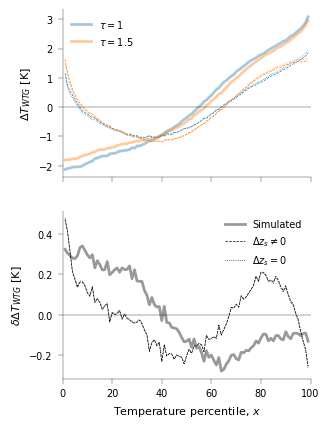

In [25]:
save_wtg_theory_fig = False
fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 2*width['one_col']/ar), sharex=True)
for i in range(n_exp):
    ax[0].plot(quantiles_all, np.average(temp_wtg_anom[i], weights=lat_weights, axis=0), color=default_colors[i], 
               label=f'$\\tau={tau_lw[i]}$', alpha=0.4, lw=2)
    ax[0].plot(quantiles_all, np.average(temp_wtg_anom_from_z['with_z_surf'][i], weights=lat_weights, axis=0), color=default_colors[i], 
               linestyle='--')
    ax[0].plot(quantiles_all, np.average(temp_wtg_anom_from_z['no_z_surf'][i], weights=lat_weights, axis=0), color=default_colors[i], 
               linestyle=':')
ax[1].plot(quantiles_all, np.average(np.diff(temp_wtg_anom, axis=0)[0], weights=lat_weights, axis=0), color='k', 
           alpha=0.4, lw=2, label='Simulated')
ax[1].plot(quantiles_all, np.average(delta_temp_wtg_anom_from_z['with_z_surf'], weights=lat_weights, axis=0),
           color='k', linestyle='--', label='$\Delta z_s \\neq 0$')
ax[1].plot(quantiles_all, np.average(delta_temp_wtg_anom_from_z['no_z_surf'], weights=lat_weights, axis=0),
           color='k', linestyle=':', label='$\Delta z_s = 0$')
ax[0].legend()
ax[1].legend()
ax[0].axhline(0, color='k', lw=ax_linewidth)
ax[1].axhline(0, color='k', lw=ax_linewidth)
ax[1].set_xlabel(percentile_label)
ax[0].set_xlim(0, 100)
ax[0].set_ylabel('$\Delta T_{WTG}$ [K]')
ax[1].set_ylabel('$\delta \Delta T_{WTG}$ [K]')
if save_fig or save_wtg_theory_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/wtg_theory_{region}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

## Theory for $\delta T_s$

Next we want to substitute these two equations into the following, and put all the $\delta T_s$ terms on the LHS. 
$\delta (h^{\dagger}(x)-\overline{h^{\dagger}}) \approx \beta_1 \delta (\Delta T_{WTG} + \Delta \overline{T_{CE}} - \Delta T_{CE}) + \frac{\beta_2}{\beta_1}\frac{(\Delta T_{WTG} + \Delta \overline{T_{CE}} - \Delta T_{CE})}{\overline{T_A}}\delta \overline{h^{\dagger}}$

In $\Delta T_{WTG}$ form, we get:

$\left(c_p - \frac{R\ln 2}{2} + L_v\alpha_s(x)q(x)\right)\delta T_s(x) + L_vq^*_s(x)\delta r(x) \approx \beta_1 \delta (\Delta T_{WTG} + \Delta \overline{T_{CE}} - \Delta T_{CE}) + \\
\left(1+\frac{\beta_2}{\beta_1}\frac{(\Delta T_{WTG} + \Delta \overline{T_{CE}} - \Delta T_{CE})}{\overline{T_A}}\right)\left((c_p - \frac{R\ln 2}{2} + L_v\bar{\alpha_s}\overline{q})\delta \overline{T_s} + L_v\overline{q^*_s}\delta \overline{r}\right)$

In $\Delta z$ form, we get:

$\left(c_p - \frac{R\ln 2}{2} + \beta_1 + L_v\alpha_s(x)q(x)\right)\delta T_s(x) + L_vq^*_s(x)\delta r(x) \approx \beta_1 \delta (\frac{2g}{R\ln 2}\Delta z + \Delta \overline{T_{CE}} - \Delta T_{CE}) + \\
\left(1+\frac{\beta_2}{\beta_1}\frac{(\frac{2g}{R\ln 2}\Delta z - \Delta T_s + \Delta \overline{T_{CE}} - \Delta T_{CE})}{\overline{T_A}}\right)\left((c_p - \frac{R\ln 2}{2} + L_v\bar{\alpha_s}\overline{q})\delta \overline{T_s} + L_v\overline{q^*_s}\delta \overline{r}\right) + \beta_1 \delta \overline{T_s}$

We can simplify this by neglecting $\delta \overline{r}$ when multiplied by a $\Delta T$ or $\Delta z$ term. Then the theory is basically the old theory plus two additional terms. One for $\delta \Delta T$ and one for $\Delta T \delta \overline{T}$.

In [26]:
delta_temp_theory = {key: np.zeros((n_lat, n_quant_all)) for key in ['wtg', 'z', 'wtg_no_rh', 'z_no_rh', 'old', 'old_no_rh', 'best', 'best_no_rh',
                                                                     'wtg_simple', 'z_simple', 'new_wtg_q', 'new_z_q', 'new_wtg_r', 'new_z_r']}
delta_temp_theory_prefactors = {key: np.zeros((n_lat, n_quant_all)) for key in 
                                ['temp_s_mean', 'r_mean', 'r_quant', 'temp_a','temp_s_mean_squared', 'temp_s_mean_temp_a0', 'r_mean_temp_a0',
                                 'temp_s_mean_squared_temp_a0', 'temp_s_mean_cubed_temp_a0', 'r_mean_squared_temp_a0', 
                                 'nl_temp_s_mean_temp_a', 'nl_r_mean_temp_a', 'nl_temp_s_mean_r_mean']}
delta_temp_theory_prefactors =  {key: copy.deepcopy(delta_temp_theory_prefactors) for key in 
                                 ['wtg', 'z', 'wtg_no_rh', 'z_no_rh', 'old', 'old_no_rh', 'wtg_simple', 'z_simple']}
delta_temp_theory_changes = copy.deepcopy(delta_temp_theory_prefactors)
delta_temp_theory_cont = copy.deepcopy(delta_temp_theory_prefactors)

delta_temp_theory_prefactors_new = {key: np.zeros((n_lat, n_quant_all)) for key in 
                                    ['temp_s', 'humidity', 'r_change', 'temp_a_change']}
delta_temp_theory_prefactors_new = {key: copy.deepcopy(delta_temp_theory_prefactors_new) for key in ['new_wtg_q', 'new_z_q', 'new_wtg_r', 'new_z_r']}
delta_temp_theory_changes_new = copy.deepcopy(delta_temp_theory_prefactors_new)
delta_temp_theory_cont_new = copy.deepcopy(delta_temp_theory_prefactors_new)

for j in range(n_lat):
    for key in delta_temp_theory:
        if 'old' in key:
            continue
        if 'best' in key:
            delta_temp_theory[key][j], _, info_coef, info_change = \
                get_delta_temp_quant_theory(temp_mean[:, ind_surf, j], temp_quant3[:, ind_surf, j], sphum_mean[humid_calc][:, j],
                                            sphum_quant3[humid_calc][:, j], p_surface, pressure_ft_actual, None, None, None, None, 
                                            'squared', 'squared', 'none' if 'no_rh' in key else 'full')
            continue
        elif 'simple' in key:
            if 'z' in key:
                delta_temp_theory[key][j], _, info_coef, info_change = \
                    get_delta_temp_quant_theory_simple(temp_mean[:, ind_surf, j], temp_quant3[:, ind_surf, j], sphum_mean[humid_calc][:, j],
                                                       sphum_quant3[humid_calc][:, j], p_surface, pressure_ft_actual, temp_mean[:, ind_ft, j],
                                                       temp_quant3[:, ind_ft, j], z_mean[:, ind_ft, j], z_quant3[:, ind_ft, j])
            elif 'wtg' in key:
                delta_temp_theory[key][j], _, info_coef, info_change = \
                    get_delta_temp_quant_theory_simple(temp_mean[:, ind_surf, j], temp_quant3[:, ind_surf, j], sphum_mean[humid_calc][:, j],
                                                       sphum_quant3[humid_calc][:, j], p_surface, pressure_ft_actual)
        elif 'new' in key:
            if 'z' in key:
                delta_temp_theory[key][j], info_coef, info_change = \
                    get_delta_temp_quant_theory_simple2(temp_mean[:, ind_surf, j], temp_quant3[:, ind_surf, j], sphum_mean[humid_calc][:, j], 
                                                        sphum_quant3[humid_calc][:, j], p_surface, pressure_ft_actual, temp_mean[:, ind_ft, j],
                                                        temp_quant3[:, ind_ft, j], z_mean[:, ind_ft, j], z_quant3[:, ind_ft, j], 
                                                        use_sphum_anom0='q' in key)
            elif 'wtg' in key:
                delta_temp_theory[key][j], info_coef, info_change = \
                    get_delta_temp_quant_theory_simple2(temp_mean[:, ind_surf, j], temp_quant3[:, ind_surf, j], sphum_mean[humid_calc][:, j], 
                                                        sphum_quant3[humid_calc][:, j], p_surface, pressure_ft_actual, use_sphum_anom0='q' in key)
            for var in info_coef:
                delta_temp_theory_prefactors_new[key][var][j] = info_coef[var]
                delta_temp_theory_changes_new[key][var][j] = info_change[var]
                delta_temp_theory_cont_new[key][var][j] = info_coef[var] * info_change[var]
            continue
        else:
            if 'z' in key:
                delta_temp_theory[key][j], _, info_coef, info_change = \
                    get_delta_temp_quant_theory(temp_mean[:, ind_surf, j], temp_quant3[:, ind_surf, j], sphum_mean[humid_calc][:, j], 
                                                sphum_quant3[humid_calc][:, j], p_surface, pressure_ft_actual, temp_mean[:, ind_ft, j], 
                                                temp_quant3[:, ind_ft, j], z_mean[:, ind_ft, j], z_quant3[:, ind_ft, j], 'linear', 'linear',
                                                'none' if 'no_rh' in key else 'approx_anomaly', 'approx')
            elif 'wtg' in key:
                delta_temp_theory[key][j], delta_temp_theory[key.replace('wtg', 'old')][j], info_coef, info_change = \
                    get_delta_temp_quant_theory(temp_mean[:, ind_surf, j], temp_quant3[:, ind_surf, j], sphum_mean[humid_calc][:, j], 
                                                sphum_quant3[humid_calc][:, j], p_surface, pressure_ft_actual, None, None, None, None, 'linear',
                                                'linear', 'none' if 'no_rh' in key else 'approx_anomaly', 'approx')
        for info_key in info_coef:
            delta_temp_theory_prefactors[key][info_key][j] = info_coef[info_key]
            delta_temp_theory_changes[key][info_key][j] = info_change[info_key]
            delta_temp_theory_cont[key][info_key][j] = info_coef[info_key] * info_change[info_key]

In [27]:
# sanity check that sum of change terms is equal to total theory
key = 'wtg'
theory_sanity_check = 0
for info_key in delta_temp_theory_cont[key]:
    if 'change' not in info_key:
        continue
    theory_sanity_check = theory_sanity_check + delta_temp_theory_cont[key][info_key]
np.max(np.abs(sum(delta_temp_theory_cont[key].values()) - delta_temp_theory[key]))

0.0

In [28]:
# sanity check that simple function works same as complete function
print('Sanity check that complete and simple functions give same result')
for key in ['wtg', 'z']:
    print(f"{key} - total: {np.max(np.abs(delta_temp_theory[key] - delta_temp_theory[key+'_simple']))}")
    for var in ['temp_s_mean', 'r_mean', 'r_quant', 'temp_a', 'temp_s_mean_temp_a0']:
        print(f"{key} - {var}: {np.max(np.abs(delta_temp_theory_cont[key][var] - delta_temp_theory_cont[key+'_simple'][var]))}")

Sanity check that complete and simple functions give same result
wtg - total: 1.7763568394002505e-15
wtg - temp_s_mean: 1.7763568394002505e-15
wtg - r_mean: 0.0
wtg - r_quant: 0.0
wtg - temp_a: 2.220446049250313e-16
wtg - temp_s_mean_temp_a0: 4.440892098500626e-16
z - total: 2.6645352591003757e-15
z - temp_s_mean: 1.7763568394002505e-15
z - r_mean: 1.1102230246251565e-16
z - r_quant: 1.1102230246251565e-16
z - temp_a: 1.1102230246251565e-16
z - temp_s_mean_temp_a0: 2.7755575615628914e-16


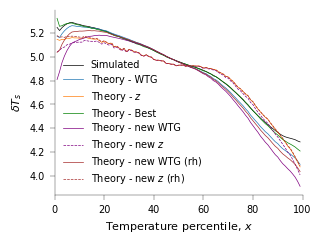

In [29]:
save_delta_temp_theory_fig = False
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar), sharex=True)
ax = [ax]
ax[0].plot(quantiles_all, np.average(temp_quant3[1, ind_surf] - temp_quant3[0, ind_surf], weights=lat_weights, axis=0), 
           color='k', label='Simulated')
# ax[0].plot(quantiles_all, np.average(delta_temp_theory['old'], weights=lat_weights, axis=0), color='r', 
#            label='Theory - Old')
# ax[0].plot(quantiles_all, np.average(delta_temp_theory['old_no_rh'], weights=lat_weights, axis=0), color='r', 
#            linestyle=':')
ax[0].plot(quantiles_all, np.average(delta_temp_theory['wtg'], weights=lat_weights, axis=0), color=default_colors[0], 
           label='Theory - WTG')
ax[0].plot(quantiles_all, np.average(delta_temp_theory['z'], weights=lat_weights, axis=0), color=default_colors[1], 
           label='Theory - $z$')
# ax[0].plot(quantiles_all, np.average(delta_temp_theory['wtg_no_rh'], weights=lat_weights, axis=0), color=default_colors[0], 
#            linestyle=':')
# ax[0].plot(quantiles_all, np.average(delta_temp_theory['z_no_rh'], weights=lat_weights, axis=0), color=default_colors[1], 
#            linestyle=':')
ax[0].plot(quantiles_all, np.average(delta_temp_theory['best'], weights=lat_weights, axis=0), color='green', 
           label='Theory - Best')
# ax[0].plot(quantiles_all, np.average(delta_temp_theory['best_no_rh'], weights=lat_weights, axis=0), color='green', 
#            linestyle=':')
ax[0].plot(quantiles_all, np.average(delta_temp_theory['new_wtg_q'], weights=lat_weights, axis=0), color='purple', 
           label='Theory - new WTG')
ax[0].plot(quantiles_all, np.average(delta_temp_theory['new_z_q'], weights=lat_weights, axis=0), color='purple', 
           label='Theory - new $z$', linestyle='--')
ax[0].plot(quantiles_all, np.average(delta_temp_theory['new_wtg_r'], weights=lat_weights, axis=0), color='brown', 
           label='Theory - new WTG (rh)')
ax[0].plot(quantiles_all, np.average(delta_temp_theory['new_z_r'], weights=lat_weights, axis=0), color='brown', 
           label='Theory - new $z$ (rh)', linestyle='--')
ax[0].set_xlabel(percentile_label)
ax[0].set_xlim(0, 100)
ax[0].legend()
ax[0].set_ylabel('$\delta T_s$')

if save_fig or save_delta_temp_theory_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/delta_temp_theory_{region}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

## Decompose $\Delta T_A$ and $\delta \Delta T_A$ terms in $\delta T_s(x)$ Theory
Below I plot the contributions of $\Delta T_A$ and $\delta \Delta T_A$ terms to the most simple linear theory.
I then decompose these contributions into the more physical convective equilibrium and WTG terms.

In [30]:
# multiply z_anom by factor used in formula so same units as temperature
z_ft_mod_anom = (z_quant3[:, ind_ft] - z_mean[:, ind_ft][:, :, np.newaxis]) * g / lnp_const 
delta_z_ft_mod_anom = z_ft_mod_anom[1] - z_ft_mod_anom[0]         
delta_temp_ce_mean = temp_ce_mean_anom[1] - temp_ce_mean_anom[0]
delta_temp_ce_quant = temp_ce_quant[1] - temp_ce_quant[0]
delta_temp_wtg_anom = temp_wtg_anom[1] - temp_wtg_anom[0]

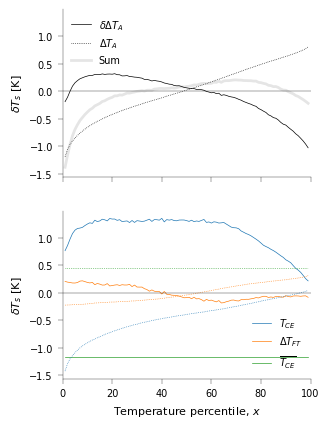

In [31]:
save_delta_temp_theory_decomp_fig = False
exp_plot = 'wtg'          # Note that these plots are the same for 'no_rh' experiments as rh changes excluded when multiply Delta T_A factors.
# Get prefactor for all terms with base climate adiabatic temp anomaly
coef_temp_a0 = sum([delta_temp_theory_cont[exp_plot][var] for var in delta_temp_theory_cont[exp_plot] if 'temp_a0' in var])/temp_adiabat_anom[0]
fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 2*width['one_col']/ar), sharex=True, sharey=True)
ax[0].plot(quantiles_all, np.average(delta_temp_theory_cont[exp_plot]['temp_a'], weights=lat_weights, axis=0),
           color='k', label='$\delta \Delta T_A$')
ax[0].plot(quantiles_all, np.average(coef_temp_a0 * temp_adiabat_anom[0], weights=lat_weights, axis=0),
           linestyle=':', color='k', label='$\Delta T_A$')
ax[0].plot(quantiles_all, np.average(delta_temp_theory_cont[exp_plot]['temp_a'] + coef_temp_a0 * temp_adiabat_anom[0], 
                                     weights=lat_weights, axis=0), lw=2, alpha=0.1, color='k', label='Sum')

ax[1].plot(quantiles_all, -np.average(delta_temp_theory_prefactors[exp_plot]['temp_a'] * delta_temp_ce_quant, weights=lat_weights, axis=0),
           color=default_colors[0], label='$T_{CE}$')
if 'wtg' in exp_plot:
    ax[1].plot(quantiles_all, np.average(delta_temp_theory_prefactors[exp_plot]['temp_a'] * delta_temp_wtg_anom, weights=lat_weights, axis=0),
               color=default_colors[1], label='$\Delta T_{FT}$')
elif 'z' in exp_plot:
    ax[1].plot(quantiles_all, np.average(delta_temp_theory_prefactors[exp_plot]['temp_a'] * delta_z_ft_mod_anom, weights=lat_weights, axis=0),
               color=default_colors[1], label='$\delta \Delta z_{FT}$')
ax[1].plot(quantiles_all, np.average(delta_temp_theory_prefactors[exp_plot]['temp_a'] * delta_temp_ce_mean[:, np.newaxis], 
                                     weights=lat_weights, axis=0), color=default_colors[2], label='$\overline{T_{CE}}$')
ax[1].plot(quantiles_all, -np.average(coef_temp_a0 * temp_ce_quant[0], weights=lat_weights, axis=0), 
           color=default_colors[0], linestyle=':')
ax[1].plot(quantiles_all, np.average(coef_temp_a0 * temp_wtg_anom[0], weights=lat_weights, axis=0), 
           color=default_colors[1], linestyle=':', label='$\Delta T_{FT}$' if 'z' in exp_plot else None)
ax[1].plot(quantiles_all, np.average(coef_temp_a0 * temp_ce_mean_anom[0][:, np.newaxis], weights=lat_weights, axis=0), 
           color=default_colors[2], linestyle=':')
ax[0].axhline(0, color='k', lw=ax_linewidth)
ax[1].axhline(0, color='k', lw=ax_linewidth)

ax[0].set_ylabel('$\delta T_s$ [K]')
ax[1].set_ylabel('$\delta T_s$ [K]')
ax[1].set_xlabel(percentile_label)
ax[0].set_xlim(0, 100)
ax[0].legend()
ax[1].legend()

if save_fig or save_delta_temp_theory_decomp_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/delta_temp_{exp_plot}_theory_decomp_{region}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

## Breakdown of New Theory
Below I plot the contributions to the scaling factor by the new theory.

In [32]:
for key in delta_temp_theory_cont_new:
    delta_temp_theory_cont_new[key]['temp_ce_change'] = delta_temp_theory_prefactors_new[key]['temp_a_change'] * \
                                                        (delta_temp_ce_mean[:, np.newaxis] - delta_temp_ce_quant)
    if 'z' in key:
        delta_temp_theory_cont_new[key]['temp_ft_change'] = delta_temp_theory_prefactors_new[key]['temp_a_change'] * delta_z_ft_mod_anom
    else:
        delta_temp_theory_cont_new[key]['temp_ft_change'] = delta_temp_theory_prefactors_new[key]['temp_a_change'] * delta_temp_wtg_anom

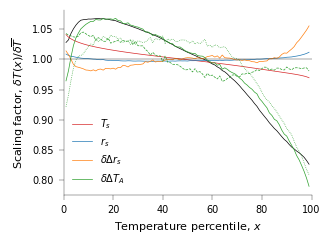

In [33]:
exp_new_plot = 'new_wtg_r'
humidity_use = exp_new_plot[-1]
colors_breakdown = {'temp_s': default_colors[3], 'humidity': default_colors[0],  
                    'r_change': default_colors[1], 'temp_a_change': default_colors[2], 
                    'temp_ce_change': default_colors[2], 'temp_ft_change': default_colors[2]}
linestyles_breakdown = {key: '-' for key in colors_breakdown}
linestyles_breakdown['temp_ce_change'] = ':'
linestyles_breakdown['temp_ft_change'] = '--'
labels_breakdown = {'temp_s': '$T_s$', 'humidity': f'${humidity_use}_s$', 'r_change': '$\delta \Delta r_s$',
                    'temp_a_change': '$\delta \Delta T_A$',
                    'temp_ce_change': None, 'temp_ft_change': None}
sf_denom = delta_temp_theory_changes_new['new_wtg_q']['temp_s']         # delta_temp_s_mean

save_sf_theory_breakdown_new_fig = False
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar), sharex=True, sharey=True)
ax = [ax]
ax[0].plot(quantiles_all, np.average(delta_temp_theory[exp_new_plot]/sf_denom, axis=0, weights=lat_weights), color='k')
for key in delta_temp_theory_cont_new[exp_new_plot]:
    ax[0].plot(quantiles_all, np.average(delta_temp_theory_cont_new[exp_new_plot][key]/sf_denom, weights=lat_weights, axis=0)+1, color=colors_breakdown[key], linestyle=linestyles_breakdown[key], label=labels_breakdown[key])
for i in range(len(ax)):
    ax[i].axhline(1, color='k', lw=ax_linewidth)
    ax[i].set_ylabel('Scaling factor, $\delta T(x)/\delta \overline{T}$')
    ax[i].legend()
ax[0].set_xlim(0,100)
ax[-1].set_xlabel(percentile_label)

if save_fig or save_sf_theory_breakdown_new_fig:
    file_name = f"sf_breakdown_{exp_new_plot}_{region.lower()}_{season}"
    fig.savefig(f"/Users/joshduffield/Desktop/{file_name}.pdf",dpi=dpi['combination'] if publish_fig else low_dpi, 
                bbox_inches='tight', pad_inches=save_pad_inches)

### Does Theory with $\delta \Delta T_{CE}(x)=0$ match a CQE theory?


In [138]:
# Compute explicitly from mse_ft_sat_quant3
mse_ft_sat_quant3 = moist_static_energy(temp_quant3[:, ind_ft], sphum_sat(temp_quant3[:, ind_ft], pressure_ft_actual), z_quant3[:, ind_ft])
mse_ft_sat_mean = moist_static_energy(temp_mean[:, ind_ft], sphum_sat(temp_mean[:, ind_ft], pressure_ft_actual), 
                                      z_mean[:, ind_ft])
mse_quant3 = moist_static_energy(temp_quant3[:, ind_surf], sphum_quant3[humid_calc], z_quant3[:, ind_surf])
mse_mean = moist_static_energy(temp_mean[:, ind_surf], sphum_mean[humid_calc], z_mean[:, ind_surf])
_, q_sat_s_x, alpha_s_x, _, beta_s2_x, _ = get_theory_prefactor_terms(temp_quant3[0, ind_surf], p_surface, pressure_ft_actual, 
                                                                      sphum_quant3[humid_calc][0, ind_surf])
scale_factor_cqe_denom = c_p + L_v * alpha_s_x * sphum_quant3[humid_calc][0]
scale_factor_cqe_numerator = -L_v * q_sat_s_x * np.diff(r_quant3[humid_calc], axis=0)[0] + np.diff(mse_ft_sat_quant3, axis=0)[0] * 1000

mse_quant3_change_taylor = (scale_factor_cqe_denom * (temp_quant3[1] - temp_quant3[0])[ind_surf] + 
                     L_v * q_sat_s_x * (r_quant3[humid_calc][1]-r_quant3[humid_calc][0])) / 1000
prefactor_mse_nonlinear = L_v * alpha_s_x * q_sat_s_x * (r_quant3[humid_calc][1]-r_quant3[humid_calc][0])
prefactor_mse_squared = 0.5 * beta_s2_x / temp_quant3[0, ind_surf]
mse_quant3_change_taylor_full = mse_quant3_change_taylor + prefactor_mse_nonlinear * (
        temp_quant3[1] - temp_quant3[0])[ind_surf] / 1000 + prefactor_mse_squared * (
        temp_quant3[1] - temp_quant3[0])[ind_surf]**2 / 1000




scale_factor_cqe = {'cqe_x':scale_factor_cqe_numerator/scale_factor_cqe_denom/sf_denom, 
                    'cqe_x_equal_mean': (scale_factor_cqe_numerator - np.diff(mse_ft_sat_mean-mse_mean, axis=0).transpose()*1000)/scale_factor_cqe_denom/sf_denom}
scale_factor_cqe_theory = (delta_temp_theory['new_wtg_r']-delta_temp_theory_cont_new['new_wtg_r']['temp_ce_change'])/sf_denom

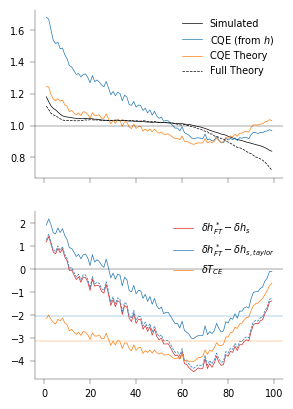

In [139]:
fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 2*width['one_col']/ar), sharex=True)
ax[0].plot(quantiles_all, np.average((temp_quant3[1, ind_surf] - temp_quant3[0, ind_surf]) / sf_denom, weights=lat_weights, axis=0), color='k',
           label='Simulated')
ax[0].plot(quantiles_all, np.average(scale_factor_cqe['cqe_x_equal_mean'], axis=0, weights=lat_weights), color=default_colors[0], 
           label='CQE (from $h$)')
# ax[0].plot(quantiles_all, np.average(scale_factor_cqe['cqe_x'], axis=0, weights=lat_weights), color=default_colors[0], alpha=0.3)
ax[0].plot(quantiles_all, np.average(scale_factor_cqe_theory, axis=0, weights=lat_weights), color=default_colors[1], label='CQE Theory')
ax[0].plot(quantiles_all, np.average(delta_temp_theory['new_wtg_r']/sf_denom, axis=0, weights=lat_weights), 
           color='k', linestyle='--', label='Full Theory')
ax[1].plot(quantiles_all, np.average((mse_ft_sat_quant3[1] - mse_ft_sat_quant3[0]) - (mse_quant3[1]-mse_quant3[0])
                                     , axis=0, weights=lat_weights)*1000/c_p, color=default_colors[3], label='$\delta h_{FT}^* - \delta h_s$')
ax[1].plot(quantiles_all, np.average((mse_ft_sat_quant3[1] - mse_ft_sat_quant3[0]) - mse_quant3_change_taylor
                                     , axis=0, weights=lat_weights)*1000/c_p, color=default_colors[0], 
           label='$\delta h_{FT}^* - \delta h_{s, taylor}$')
ax[1].plot(quantiles_all, np.average((mse_ft_sat_quant3[1] - mse_ft_sat_quant3[0]) - mse_quant3_change_taylor_full
                                     , axis=0, weights=lat_weights)*1000/c_p, color=default_colors[0], linestyle='--')
ax[1].plot(quantiles_all, np.average(temp_ce_quant[1] - temp_ce_quant[0], axis=0, weights=lat_weights), color=default_colors[1], 
           label='$\delta T_{CE}$')
ax[1].axhline(np.average((mse_ft_sat_mean[1] - mse_ft_sat_mean[0]) - (mse_mean[1]-mse_mean[0]), axis=0, weights=lat_weights)*1000/c_p,
              color=default_colors[0], lw=ax_linewidth)
ax[1].axhline(np.average(temp_ce_mean_anom[1] - temp_ce_mean_anom[0], axis=0, weights=lat_weights), 
              color=default_colors[1], lw=ax_linewidth)
for i in range(2):
    ax[i].axhline(1-i, color='k', lw=ax_linewidth)
ax[0].legend()
ax[1].legend()